In [1]:
import trainer
import numpy as np 
import matplotlib.pyplot as plt


In [2]:
splited_dataset = trainer.prepare_data()     

Data exported successfully.


  1%|          | 1/117 [00:01<03:51,  2.00s/it]c:\Users\Hoon\Nextcloud3\Projects\soundClassifier\soundClassifier\trainer.py:86: UserWarning: PySoundFile failed. Trying audioread instead.
  audio_waveform, sample_rate = librosa.load(path, sr=32000)
c:\Users\Hoon\Nextcloud3\Projects\AudioTrain\.venv\lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
 81%|████████  | 95/117 [00:09<00:02,  8.78it/s]

3f84618c-spacelab3.m4a
<class 'IndexError'> trainer.py 84
list index out of range


100%|██████████| 117/117 [00:11<00:00, 10.04it/s]


In [3]:
mfcc_features = trainer.get_mfcc(splited_dataset)
mfcc_features = {label: (features * 3 if label != 'Rolling Carts' else features) for label, features in mfcc_features.items()}

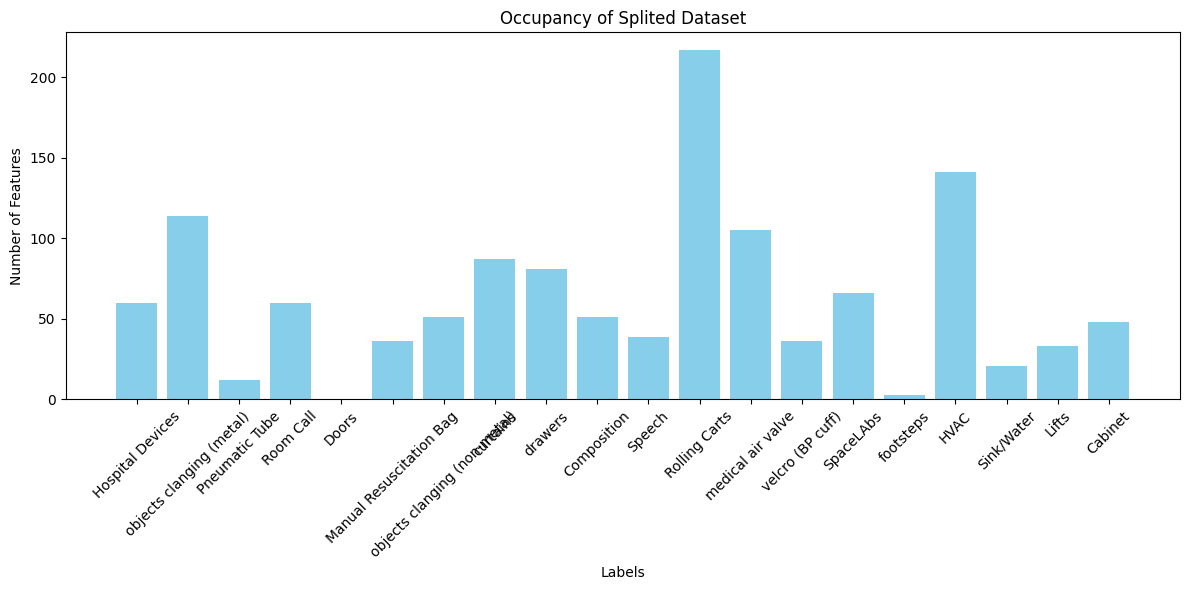

In [4]:
# Visualize the occupancy of the splited dataset
occupancy = {label: len(features) for label, features in mfcc_features.items()}
labels = list(occupancy.keys())
values = list(occupancy.values())

plt.figure(figsize=(12, 6))
plt.bar(labels, values, color='skyblue')
plt.xlabel('Labels')
plt.ylabel('Number of Features')
plt.title('Occupancy of Splited Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [5]:

x_train, x_test, y_train, y_test, label = trainer.split_data(mfcc_features)
with open('labels.txt', 'w') as f:
    for lbl in label:
        f.write(f"{lbl}\n")



Training set size: 882
Testing set size: 379


In [6]:
model = trainer.build_model(x_train, x_test, y_train, y_test)

c:\Users\Hoon\Nextcloud3\Projects\AudioTrain\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 40, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20, 64)         │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 20, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10, 128)        │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 5, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 640)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       328,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 19)             │         9,747 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 383,571 (1.46 MB)

 Trainable params: 383,571 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1771 - loss: 6.8925 - val_accuracy: 0.6121 - val_loss: 1.4021
Epoch 2/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5543 - loss: 1.4740 - val_accuracy: 0.7599 - val_loss: 0.8294
Epoch 3/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6743 - loss: 1.0342 - val_accuracy: 0.8575 - val_loss: 0.5697
Epoch 4/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8085 - loss: 0.6552 - val_accuracy: 0.8865 - val_loss: 0.4423
Epoch 5/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8339 - loss: 0.5821 - val_accuracy: 0.9208 - val_loss: 0.3234
Epoch 6/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8696 - loss: 0.4182 - val_accuracy: 0.9420 - val_loss: 0.2979
Epoch 7/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8955 - loss: 0.3572 - val_accuracy: 0.9208 - val_loss: 0.2418
Epoch 8/100
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8816 - loss: 0.3534 - val_accu

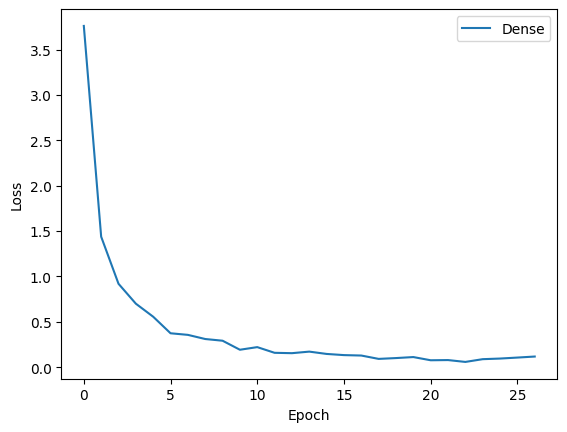

In [7]:

trainer.train(model, x_train, x_test, y_train, y_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9546 - loss: 0.1138 
Test Loss: 0.1134
Test Accuracy: 0.9551
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
                              precision    recall  f1-score   support

            Hospital Devices       0.89      1.00      0.94        17
    objects clanging (metal)       0.97      1.00      0.98        32
              Pneumatic Tube       1.00      1.00      1.00         3
                   Room Call       1.00      1.00      1.00        17
    Manual Resuscitation Bag       1.00      1.00      1.00        10
objects clanging (non-metal)       0.96      1.00      0.98        23
                    curtains       1.00      1.00      1.00        26
                     drawers       1.00      0.81      0.90        27
                 Composition       1.00      1.00      1.00        15
                      Speech       1.00      1.00      1.00        12
               Rolling Carts       0.94      0.94      0.94        69
      

c:\Users\Hoon\Nextcloud3\Projects\AudioTrain\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hoon\Nextcloud3\Projects\AudioTrain\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Hoon\Nextcloud3\Projects\AudioTrain\.venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{m

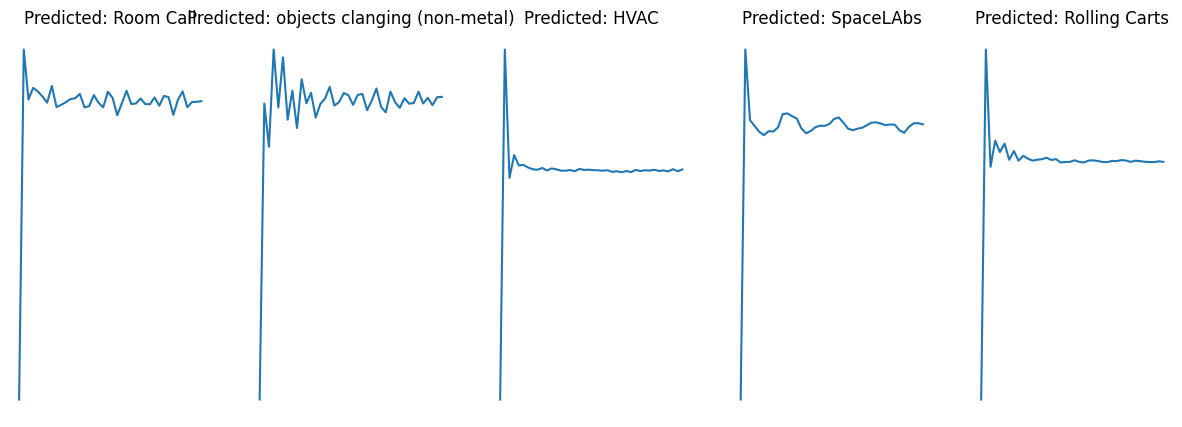

In [8]:
trainer.evaluate(model, x_test, y_test, label)

In [9]:
import tensorflow as tf
# Convert the model to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to a .tflite file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\Hoon\AppData\Local\Temp\tmps7pc65ta\assets


INFO:tensorflow:Assets written to: C:\Users\Hoon\AppData\Local\Temp\tmps7pc65ta\assets


Saved artifact at 'C:\Users\Hoon\AppData\Local\Temp\tmps7pc65ta'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 40, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 19), dtype=tf.float32, name=None)
Captures:
  1997159469952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1997159474880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1999209128608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1999209125616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1999209135824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1999128539584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1999209011280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1999209012160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1999209189216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1999209190096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  19992091976

In [10]:
def predict_labels(x_test, model_path='model.tflite'):
    # Load the TFLite model
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Prepare the input data
    x_test_input = np.array([x_test.reshape(1, len(x_test), 1)], dtype=np.float32)
    
    # Set the tensor for the input
    interpreter.set_tensor(input_details[0]['index'], x_test_input[0])

    # Run the model
    interpreter.invoke()

    # Get the output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])

    # Process the output data
    predicted_classes_tflite = np.argmax(output_data, axis=1)[0]
    # Get the labels from the dataset
    
    return predicted_classes_tflite

In [11]:
t = len(x_test)
for x, y in zip(x_test, y_test):
    resx = label[predict_labels(x)]
    resy = label[np.argmax(y)]
    if resx != resy:
        print(resx, '\t\t != \t' , resy)
        t -=1

print(t/len(x_test))

medical air valve 		 != 	 Sink/Water
Hospital Devices 		 != 	 Rolling Carts
medical air valve 		 != 	 Sink/Water
Cabinet 		 != 	 drawers
objects clanging (non-metal) 		 != 	 Rolling Carts
objects clanging (metal) 		 != 	 Rolling Carts
medical air valve 		 != 	 Sink/Water
Rolling Carts 		 != 	 drawers
Rolling Carts 		 != 	 drawers
medical air valve 		 != 	 Sink/Water
Rolling Carts 		 != 	 drawers
Hospital Devices 		 != 	 Rolling Carts
medical air valve 		 != 	 Sink/Water
medical air valve 		 != 	 Sink/Water
Rolling Carts 		 != 	 drawers
medical air valve 		 != 	 Sink/Water
medical air valve 		 != 	 Sink/Water
0.9551451187335093
